# Chargement des données

Pour faciliter l'import du dossier, et à cause du fait que l'environnement d'exécution est nettoyé après une déconnexion, nous avons importé le dossier dans notre Drive et nous avons établi une connexion avec notre notebook.

In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1EEsjVZHlJpcP7ETpVIc02QEnWsa_1Ook'})
download.GetContentFile('nifti.zip')

In [0]:
!unzip nifti.zip

Archive:  nifti.zip
   creating: nifti/
 extracting: nifti/.DS_Store         
   creating: nifti/496/
 extracting: nifti/496/Shank_496-labels.atlas.xml  
 extracting: nifti/496/Shank_496-labels.nii  
 extracting: nifti/496/Shank_496.ibw.nii  
   creating: nifti/497/
 extracting: nifti/497/Shank_497-labels.atlas.xml  
 extracting: nifti/497/Shank_497-labels.nii  
 extracting: nifti/497/Shank_497.ibw.nii  
   creating: nifti/499/
 extracting: nifti/499/Shank_499-labels.atlas.xml  
 extracting: nifti/499/Shank_499-labels.nii  
 extracting: nifti/499/Shank_499.ibw.nii  
   creating: nifti/506/
 extracting: nifti/506/Shank_506-labels.atlas.xml  
 extracting: nifti/506/Shank_506-labels.nii  
 extracting: nifti/506/Shank_506.ibw.nii  
   creating: nifti/515/
 extracting: nifti/515/Shank_515-labels.atlas.xml  
 extracting: nifti/515/Shank_515-labels.nii  
 extracting: nifti/515/Shank_515.ibw.nii  
   creating: nifti/520/
 extracting: nifti/520/Shank_520-labels.atlas.xml  
 extracting: nifti/52

In [0]:
!rm -rf nifti/data_test_sans_masque/

In [0]:
!rm -rf nifti/nifti_em/

# **Mise en forme des données**

In [0]:
#from future import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import os
from keras import backend as K
from nibabel.testing import data_path
import nibabel as nib 
import matplotlib.pyplot
from sklearn.model_selection import train_test_split
from skimage import exposure, measure,transform
from random import sample
from tensorflow.python import math_ops
import random

print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))




2.1.0
/device:GPU:0
Num GPUs Available:  1


**Import des données**

Nous utilisons le parcours hiérarchique de nos dossiers pour lire les fichiers, extraire la fdata et avoir les slices au même temps.

In [0]:


DATA = '/content/nifti/'

data_feature, data_label = [], []
for subdir,dirs, files in os.walk(DATA):
    #print("", os.listdir('.'))
    for file in files:
        name= os.path.join(subdir, file)
        #print("", name)
        if name.endswith(".nii") :
            if not ("-labels" in name):
                img_data = nib.load(name).get_fdata()
                for j in range(1,128):
                    data_feature.append(img_data[:,:,j])
                    data_feature.append(img_data[j,:,:])
                    data_feature.append(img_data[:,j,:])

            else:
                label_data = nib.load(name).get_fdata()
                for j in range(1,128):
                    data_label.append(label_data[:,:,j])
                    data_label.append(label_data[j,:,:])
                    data_label.append(label_data[:,j,:])
                

In [0]:
range(1,len(data_feature))

range(1, 6096)


Nous avons constaté que certains labels sont à 2 au lieu de 1, nous normalisons tous les labels.


In [0]:
no_brain_label = []
no_brain_feature = []

for i in range(len(data_label)-1,0,-1):
  has_brain = 0
  for j in range(1,128):
    for k in range(1,128):
      if (data_label[i][j][k] > 1): 
        data_label[i][j][k] = 1.
      if (data_label[i][j][k] == 1.):
        has_brain=1
  if (not has_brain):
    no_brain_label.append(data_label.pop(i))
    no_brain_feature.append(data_feature.pop(i))

#**Modèle**

##Set input pipeline

Extraire le jeu de données d'entraînement et de test à partir des Datasets initauxn en utilisant la fonction split de numpy. Nous avons choisi d'entraîner 80% des données.



In [0]:
proportion = int(len(data_feature) * 0.8)

#Split dataset  into train and test sets
sub_data = np.split(data_feature, [ proportion, len(data_feature)])
x_train = tf.expand_dims(tf.convert_to_tensor(sub_data[0], dtype = tf.float64), -1)
x_test = tf.expand_dims(tf.convert_to_tensor(sub_data[1], dtype = tf.float64), -1) 

#Split labels into train and test
sub_label = np.split(data_label, [ proportion, len(data_label)])
y_train = tf.expand_dims(tf.convert_to_tensor(sub_label[0], dtype = tf.float32), -1)
y_test = tf.expand_dims(tf.convert_to_tensor(sub_label[1], dtype = tf.float32), -1) 

Quelle est la taille de x_train ?

In [0]:
print("x_train Shape: ", x_train.shape)
print("y_train Shape: ", y_train.shape)  

x_train Shape:  (2964, 128, 128, 1)
y_train Shape:  (2964, 128, 128, 1)


In [0]:
BATCH_SIZE = 64

train_data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train), tf.data.Dataset.from_tensor_slices(y_train))).batch(BATCH_SIZE)
test_data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test), tf.data.Dataset.from_tensor_slices(y_test))).batch(BATCH_SIZE)

## Couches

On se base sur le modèle U-net

In [0]:
input_size = (128,128,1)
inputs = tf.keras.layers.Input(input_size)
conv1 = tf.keras.layers.Conv2D(64, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = tf.keras.layers.Conv2D(64, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(128, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = tf.keras.layers.Conv2D(128, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = tf.keras.layers.Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = tf.keras.layers.Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = tf.keras.layers.Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = tf.keras.layers.Dropout(0.5)(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = tf.keras.layers.Conv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = tf.keras.layers.Conv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = tf.keras.layers.Dropout(0.5)(conv5)

up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
conv6 = tf.keras.layers.Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = tf.keras.layers.Conv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
conv7 = tf.keras.layers.Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = tf.keras.layers.Conv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
conv8 = tf.keras.layers.Conv2D(128, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = tf.keras.layers.Conv2D(128, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
conv9 = tf.keras.layers.Conv2D(64, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = tf.keras.layers.Conv2D(64, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = tf.keras.layers.Conv2D(2, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

unet = tf.keras.Model(inputs, conv10)

## Loss et metrics

In [0]:
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = pixel_wise_softmax(tf.keras.backend.flatten(y_pred))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return -(2. * intersection) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

#**Entrainement**

## callbacks

In [0]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    elif epoch >= 7 and epoch < 12:
        return 1e-6
    else:
        return 1e-8

class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      unet.optimizer.lr.numpy()))

earlystopper = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, verbose=1)

callbacks = [
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR(),
    earlystopper
]

Premier entraînement : Nous entraînons notre réseau avec le jeu de données initial, en utilisant dice_coef pour la loss et en rajoutant MeanIoU pour plus de visibilité sur la performance du réseau.

In [0]:
unet.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), 
              loss = dice_coef, 
              metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])


unet.fit(train_data, epochs=12, callbacks=callbacks, use_multiprocessing=True)

Train for 47 steps
Epoch 1/12
46/47 [============================>.] - ETA: 0s - loss: -1.9440e-06 - accuracy: 0.1680 - mean_io_u_23: 0.0904
Learning rate for epoch 1 is 0.0010000000474974513
47/47 [==============================] - 18s 389ms/step - loss: -2.0352e-06 - accuracy: 0.1684 - mean_io_u_23: 0.0906
Epoch 2/12
46/47 [============================>.] - ETA: 0s - loss: -1.9894e-06 - accuracy: 0.2135 - mean_io_u_23: 0.1198
Learning rate for epoch 2 is 0.0010000000474974513
47/47 [==============================] - 16s 343ms/step - loss: -2.0850e-06 - accuracy: 0.2140 - mean_io_u_23: 0.1201
Epoch 3/12
46/47 [============================>.] - ETA: 0s - loss: -2.1549e-06 - accuracy: 0.4206 - mean_io_u_23: 0.2537
Learning rate for epoch 3 is 0.0010000000474974513
47/47 [==============================] - 16s 343ms/step - loss: -2.2653e-06 - accuracy: 0.4207 - mean_io_u_23: 0.2539
Epoch 4/12
46/47 [============================>.] - ETA: 0s - loss: -2.5319e-06 - accuracy: 0.6339 - mean_io

##Résultats

In [0]:
loss = unet.evaluate(x_test,y_test)

742/742 [==============================] - 2s 3ms/sample - loss: -5.6927e-06 - accuracy: 0.6576 - mean_io_u_23: 0.4348


Expected mask


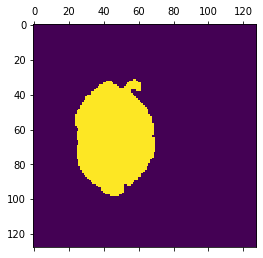

In [0]:

#Plot expected result

y_test_array = np.array(y_test)   
print("Expected mask")
expected = y_test_array[10]
matplotlib.pyplot.matshow(expected.reshape((128, 128)))


What we got


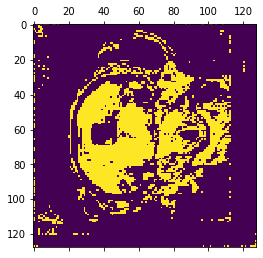

In [0]:
#plot our result

print("What we got")
predicted = model.predict(x_test)
model_result = predicted[10]
matplotlib.pyplot.matshow(model_result.reshape((128, 128)))

#**Résultats avec weights**
Dans cette partie on va comparer l'entrainement de notre réseau avec un poids sur les pixels pour que le réseau de neuronne prenne plus en compte certaine parties que d'autres.

## Définition des fonctions de poids

In [0]:
y_train.shape

TensorShape([2964, 128, 128, 1])

In [0]:

#from https://github.com/ebouilhol/deepmeta/blob/master/weighted.py

def weight_map(label, a, b):
    """
    Création du carte de poids définissant une valeur d'importance pour chaque pixel
    Les pixels n'appartenant pas au masque ont une valeur de poids définit à 1 par défaut
    :param label: ensemble de x masque label 128x128
    :param a: valeur du poids pour pixel appartenant au maque
    :param b: valeur du poids pour pixel appartenant au contour du maque
    :return: ensemble de y weight map 128x128
    """
    weights = np.zeros((label.shape[0], 128, 128))

    for k in np.arange(label.shape[0]):

        lab = label[k]
        contour = measure.find_contours(lab, 0.8)
        indx_mask = np.where(lab == 1)[0]
        indy_mask = np.where(lab == 1)[1]

        w = np.ones((128, 128))
        w[indx_mask, indy_mask] = a

        for i in np.arange(len(contour)):
            indx_cont = np.array(contour[i][:, 0], dtype='int')
            indy_cont = np.array(contour[i][:, 1], dtype='int')
            w[indx_cont, indy_cont] = b

        #w = w ** 2
        weights[k] = w

    return(weights)



In [0]:
weight_2D = weight_map(sub_label[0], 2, 4)

data_2D = sub_data[0].reshape(-1, 128, 128, 1)
label_2D = sub_label[0].reshape(-1, 128, 128, 1)
weight_2D = weight_2D.reshape(-1, 128, 128, 1)

y = np.zeros((data_2D.shape[0], 128, 128, 2))
y[:, :, :, 0] = label_2D[:, :, :, 0]
y[:, :, :, 1] = weight_2D[:, :, :, 0]

In [0]:
#https://github.com/ebouilhol/deepmeta

def weighted_cross_entropy(y_true, y_pred):
    """
    -- Fonction de coût pondéré --
    :param y_true: vrai valeur de y (label)
    :param y_pred: valeur prédite de y par le modèle
    :return: valeur de la fonction de cout d'entropie croisée pondérée
    """
    try:
        [seg, weight] = tf.unstack(y_true, 2, axis=3)

        seg = tf.expand_dims(seg, -1)
        weight = tf.expand_dims(weight, -1)
    except:
        pass

    epsilon = tf.convert_to_tensor(10e-8, y_pred.dtype.base_dtype)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    y_pred = tf.compat.v1.log(y_pred / (1 - y_pred))

    zeros = tf.zeros_like(y_pred, dtype=y_pred.dtype)  #array_ops
    cond = (y_pred >= zeros)
    relu_logits = math_ops.select(cond, y_pred, zeros)
    neg_abs_logits = math_ops.select(cond, -y_pred, y_pred)
    entropy = math_ops.add(relu_logits - y_pred * seg, math_ops.log1p(math_ops.exp(neg_abs_logits)), name=None)
    return K.mean(math_ops.multiply(weight, entropy), axis=-1)


##Entrainement du réseau
###Callbacks

In [0]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay2(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    elif epoch >= 7 and epoch < 12:
        return 1e-6
    else:
        return 1e-8

class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      unet.optimizer.lr.numpy()))

earlystopper = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, verbose=1)


callbacks2 = [
    tf.keras.callbacks.LearningRateScheduler(decay2),
    PrintLR(),
]

In [0]:
unet_w  = tf.keras.Model(inputs, conv10)
unet_w .compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), 
              loss = weighted_cross_entropy,
              metrics = ['accuracy'])


unet_w.fit(data_2D, y, epochs=12, callbacks=callbacks2, use_multiprocessing=True)

Train on 2964 samples
Epoch 1/12
2944/2964 [============================>.] - ETA: 0s - loss: 4.3177 - accuracy: 0.4362
Learning rate for epoch 1 is 9.999999974752427e-07
2964/2964 [==============================] - 18s 6ms/sample - loss: 4.3135 - accuracy: 0.4363
Epoch 2/12
2944/2964 [============================>.] - ETA: 0s - loss: 4.3105 - accuracy: 0.4363
Learning rate for epoch 2 is 9.999999974752427e-07
2964/2964 [==============================] - 17s 6ms/sample - loss: 4.3135 - accuracy: 0.4363
Epoch 3/12
2944/2964 [============================>.] - ETA: 0s - loss: 4.3101 - accuracy: 0.4363
Learning rate for epoch 3 is 9.999999974752427e-07
2964/2964 [==============================] - 17s 6ms/sample - loss: 4.3135 - accuracy: 0.4363
Epoch 4/12
2944/2964 [============================>.] - ETA: 0s - loss: 4.3171 - accuracy: 0.4362
Learning rate for epoch 4 is 9.999999974752427e-07
2964/2964 [==============================] - 17s 6ms/sample - loss: 4.3135 - accuracy: 0.4363
Epoch 

In [0]:
weight_2D_test = weight_map(sub_label[1], 2, 4)

data_2D_test = sub_data[1].reshape(-1, 128, 128, 1)
label_2D_test = sub_label[1].reshape(-1, 128, 128, 1)
weight_2D_test = weight_2D_test.reshape(-1, 128, 128, 1)

y = np.zeros((data_2D_test.shape[0], 128, 128, 2))
y[:, :, :, 0] = y_test[:, :, :, 0]
y[:, :, :, 1] = weight_2D_test[:, :, :, 0]

unet_w.evaluate(x_test, y)

742/742 [==============================] - 2s 2ms/sample - loss: 0.7131 - accuracy: 0.4360


[0.713143563495492, 0.43600962]

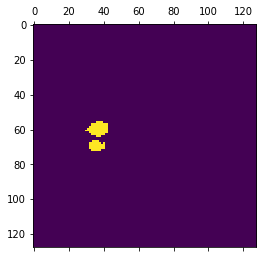

In [0]:
y = np.zeros((data_2D.shape[0], 128, 128, 2))
y[:, :, :, 0] = label_2D[:, :, :, 0]
y[:, :, :, 1] = weight_2D[:, :, :, 0]

matplotlib.pyplot.matshow(y_train[2,:,:,0])

Weight map


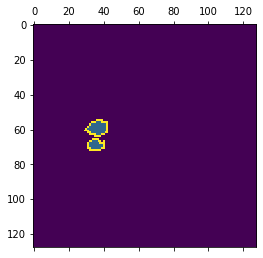

In [0]:
print("Weight map")

weights = weight_2D[2]
matplotlib.pyplot.matshow(weights.reshape((128, 128)))

What we got


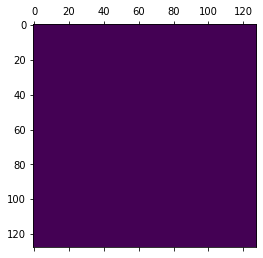

In [0]:
print("What we got")
predicted_wei = unet_w.predict(x_test)
model_weigh_result = predicted_wei[2]
matplotlib.pyplot.matshow(model_weigh_result.reshape((128, 128)))

#Augmentation de données



Au début, nous avons essayé d'utiliser la classe ImageDataGenerator de Keras, mais nous n'avons pas pu avoir des résultats.  Nous avons donc décidé d'essayer quelques transformations de Tensorflow : Rotation et découpage

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show

#https://www.kaggle.com/shenmbsw/data-augmentation-and-tensorflow-u-net

def aug_data(old_train, old_label,angel=30,resize_rate=1):

    flip = random.randint(0, 1)
    size = int(old_train.shape[0])
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    

    # Create Afine transform
    afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
    # Randomly corpping image frame
    old_train = old_train[w_s:w_s+size,h_s:h_s+size,:]
    old_label = old_label[w_s:w_s+size,h_s:h_s+size]
    # Ramdomly flip frame
    if flip:
        old_train = old_train[:,::-1,:]
        old_label = old_label[:,::-1]
    return old_train, old_label



In [0]:
new_train, new_label = aug_data(x_train, y_train)
new_xtest, new_ytest = aug_data(x_test, y_test)


Ici, on concatène l'ancien jeu d'entraînement et celui que nous avons obtenu après la fonction d'augmentation pour avoir un nouveau set.

In [0]:
train = tf.concat([x_train,new_train],0)
label = tf.concat([y_train,new_label],0)

xtest = tf.concat([x_test, new_xtest],0)
ytest = tf.concat([y_test, new_ytest],0)

dataset = tf.data.Dataset.from_tensor_slices((train, label))
dataset = dataset.batch(64).repeat()


In [0]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay3(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    elif epoch >= 7 and epoch < 12:
        return 1e-6
    else:
        return 1e-8

class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

earlystopper = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, verbose=1)


callbacks3 = [
    tf.keras.callbacks.LearningRateScheduler(decay3),
   
]

In [0]:
model_aug = tf.keras.Model(inputs, conv10)
model_aug.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), 
              loss = dice_coef, 
              metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])


model_aug.fit(dataset, epochs=12, steps_per_epoch=60,  use_multiprocessing=True)


Train for 60 steps
Epoch 1/12
60/60 [==============================] - 23s 380ms/step - loss: -2.4533e-06 - accuracy: 0.7535 - mean_io_u_20: 0.5141
Epoch 2/12
60/60 [==============================] - 20s 341ms/step - loss: -2.4799e-06 - accuracy: 0.7554 - mean_io_u_20: 0.5152
Epoch 3/12
60/60 [==============================] - 21s 344ms/step - loss: -2.4594e-06 - accuracy: 0.7559 - mean_io_u_20: 0.5156
Epoch 4/12
60/60 [==============================] - 20s 341ms/step - loss: -2.4832e-06 - accuracy: 0.7472 - mean_io_u_20: 0.5093
Epoch 5/12
60/60 [==============================] - 20s 341ms/step - loss: -2.4849e-06 - accuracy: 0.7566 - mean_io_u_20: 0.5179
Epoch 6/12
60/60 [==============================] - 21s 343ms/step - loss: -2.4605e-06 - accuracy: 0.7620 - mean_io_u_20: 0.5208
Epoch 7/12
60/60 [==============================] - 20s 341ms/step - loss: -2.4869e-06 - accuracy: 0.7523 - mean_io_u_20: 0.5132
Epoch 8/12
60/60 [==============================] - 20s 341ms/step - loss: -2.

In [0]:
print("What we got")
predicted_aug = model_aug.predict(x_test)
model_aug_result = predicted_aug[64]
matplotlib.pyplot.matshow(model_aug_result.reshape((128, 128)))

# **Augmentation avec des fenêtres**
Ici on veut faire de la data augmentation à l'aide de fenêtre sur les images originales. 

Notre problème vient du fait qu'on ne veut pas mettre des images trop random dans notre jeu de données



##Réseau de test des fenêtres
On entraine un réseau qui va nous servir à estimer si une fenêtre bonne ou pas



In [0]:
  #Instantiate an empty model
alexnet = tf.keras.Sequential()

# 1st Convolutional Layer
alexnet.add(tf.keras.layers.Conv2D(96, activation='relu', input_shape=(128,128,1), kernel_size=(11,11), strides=(4,4), padding='same', kernel_initializer = 'he_normal'))
# Max Pooling
alexnet.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 2nd Convolutional Layer
alexnet.add(tf.keras.layers.Conv2D(256, activation='relu',kernel_size=(11,11), strides=(1,1), padding='same', kernel_initializer = 'he_normal'))
# Max Pooling
alexnet.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 3rd Convolutional Layer
alexnet.add(tf.keras.layers.Conv2D(384, activation='relu',kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer = 'he_normal'))

# 4th Convolutional Layer
alexnet.add(tf.keras.layers.Conv2D(384, activation='relu',kernel_size=(3,3), strides=(1,1), padding='same'))

# 5th Convolutional Layer
alexnet.add(tf.keras.layers.Conv2D(256, activation='relu',kernel_size=(3,3), strides=(1,1), padding='same'))
# Max Pooling
alexnet.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# Passing it to a Fully Connected layer
alexnet.add(tf.keras.layers.Flatten())
# 1st Fully Connected Layer
alexnet.add(tf.keras.layers.Dense(4096, activation='relu',input_shape=(224*224*3,)))
# Add Dropout to prevent overfitting
alexnet.add(tf.keras.layers.Dropout(0.4))

# 2nd Fully Connected Layer
alexnet.add(tf.keras.layers.Dense(4096, activation='relu'))
# Add Dropout
alexnet.add(tf.keras.layers.Dropout(0.4))

# 3rd Fully Connected Layer
alexnet.add(tf.keras.layers.Dense(1000, activation='relu'))
# Add Dropout
alexnet.add(tf.keras.layers.Dropout(0.4))

# Output Layer
alexnet.add(tf.keras.layers.Dense(17, activation='softmax'))

alexnet.summary()

# Compile the model
alexnet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 32, 32, 96)        11712     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 16, 16, 256)       2973952   
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 8, 8, 384)         1327488   
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 8, 8, 256)       

Pour les données on prend uniquement des images de cerveaux

In [0]:
data_label_f = data_label.copy()
data_feature_f = data_feature.copy()


for i in range(len(data_label)-1,0,-1):
  number_brain = 0
  for j in range(1,128):
    for k in range(1,128):
      if (data_label_f[i][j][k] > 1): 
        data_label[i][j][k] = 1.
      if (data_label_f[i][j][k] == 1.):
        number_brain+=1
  if (number_brain<500):
    data_label_f.pop(i)
    data_feature_f.pop(i)
len(data_feature_f)

3272

Maintenant on a uniquement des images de cerveaux. On ajoute les noms images de cerveaux.

In [0]:
data_label_f = np.concatenate((np.ones((len(data_label_f))), np.zeros(len(no_brain_label))), axis=0)
data_feature_f = np.concatenate((data_feature_f, no_brain_feature), axis=0)
print(len(data_feature_f))
print(len(data_label_f))

5662
5662


In [0]:
data_label_f

array([1., 1., 1., ..., 0., 0., 0.])

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
    
data_label_f, data_feature_f = unison_shuffled_copies(data_label_f, data_feature_f)

In [0]:
proportion = int(len(data_feature_f) * 0.8)


#Split dataset  into train and test sets
sub_data_f = np.split(data_feature_f, [ proportion, len(data_feature_f)])
x_train_f = tf.expand_dims(tf.convert_to_tensor(sub_data_f[0], dtype = tf.float64), -1)
x_test_f = tf.expand_dims(tf.convert_to_tensor(sub_data_f[1], dtype = tf.float64), -1) 

#Split labels into train and test
sub_label_f = np.split(data_label_f, [ proportion, len(data_label_f)])
y_train_f = tf.expand_dims(tf.convert_to_tensor(sub_label_f[0], dtype = tf.int32), -1)
y_test_f = tf.expand_dims(tf.convert_to_tensor(sub_label_f[1], dtype = tf.int32), -1) 

In [0]:
BATCH_SIZE = 64

train_data_f = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_f), tf.data.Dataset.from_tensor_slices(y_train_f))).batch(BATCH_SIZE)
test_data_f = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test_f), tf.data.Dataset.from_tensor_slices(y_test_f))).batch(BATCH_SIZE)

In [0]:
train_data_f

<BatchDataset shapes: ((None, 128, 128, 1), (None, 1)), types: (tf.float64, tf.int32)>

In [0]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay_f(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    elif epoch >= 7 and epoch < 12:
        return 1e-6
    else:
        return 1e-8

class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))


callbacks_f = [
    tf.keras.callbacks.LearningRateScheduler(decay_f),
    PrintLR(),
]

In [0]:
alexnet.fit(train_data_f, epochs=12, callbacks=callbacks_f, use_multiprocessing=True)

Train for 71 steps
Epoch 1/12
69/71 [============================>.] - ETA: 0s - loss: 8.7736 - accuracy: 0.4309
Learning rate for epoch 1 is 0.0010000000474974513
71/71 [==============================] - 2s 24ms/step - loss: 8.7731 - accuracy: 0.4309
Epoch 2/12
70/71 [============================>.] - ETA: 0s - loss: 8.7699 - accuracy: 0.4311
Learning rate for epoch 2 is 0.0010000000474974513
71/71 [==============================] - 2s 24ms/step - loss: 8.7726 - accuracy: 0.4309
Epoch 3/12
70/71 [============================>.] - ETA: 0s - loss: 8.7707 - accuracy: 0.4311
Learning rate for epoch 3 is 0.0010000000474974513
71/71 [==============================] - 2s 24ms/step - loss: 8.7733 - accuracy: 0.4309
Epoch 4/12
70/71 [============================>.] - ETA: 0s - loss: 8.7697 - accuracy: 0.4311
Learning rate for epoch 4 is 0.0010000000474974513
71/71 [==============================] - 2s 25ms/step - loss: 8.7723 - accuracy: 0.4309
Epoch 5/12
70/71 [============================>.]

KeyboardInterrupt: ignored

# Nouvelle section

## Augmentation avec les fenêtres